In [3]:
!pip install --force-reinstall --no-cache-dir "datasets==2.19.1" "pyarrow==14.0.2"
!pip install "numpy<2.0" --upgrade

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.1/62.1 kB 69.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 91.2/91.2 kB 303.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.7/57.7 kB 259.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.1/75.1 kB 279.0 MB/s eta 0:00:00
INFO: pip is looking at multiple versions of multiprocess to determine which version is compatible with other requirements. This could take a while.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 542.0/542.0 kB 104.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 38.0/38.0 MB 318.5 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 302.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 172.0/172.0 kB 294.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 237.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 516.0/516.0 kB 325.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [4]:

from datasets import load_dataset
import random

dataset = load_dataset("Hemg/AI-Generated-vs-Real-Images-Datasets", split="train")

ai_imgs = [ex for ex in dataset if ex["label"] == 0]
real_imgs = [ex for ex in dataset if ex["label"] == 1]

num_samples = min(len(ai_imgs), len(real_imgs)) // 2
ai_subset = random.sample(ai_imgs, num_samples)
real_subset = random.sample(real_imgs, num_samples)

subset = ai_subset + real_subset
random.shuffle(subset)

print(f"Usando {len(subset)} imágenes balanceadas")


Generating train split:   0%|          | 0/152710 [00:00<?, ? examples/s]

Usando 71536 imágenes balanceadas


In [5]:
import numpy as np
from PIL import Image
import tensorflow as tf
from tensorflow.keras.applications.resnet import preprocess_input
import random  # recuerda importar random

IMG_SIZE = (224, 224)
BATCH_SIZE = 8

def data_generator(samples, batch_size=BATCH_SIZE, shuffle=True):
    while True:
        if shuffle:
            random.shuffle(samples)  # solo baraja si está activado
        for i in range(0, len(samples), batch_size):
            batch = samples[i:i+batch_size]
            images, labels = [], []
            for ex in batch:
                img = ex["image"].convert("RGB").resize(IMG_SIZE)
                img_array = np.array(img, dtype="float32")
                img_preprocessed = preprocess_input(img_array)
                images.append(img_preprocessed)
                labels.append(ex["label"])
            yield np.array(images), np.array(labels)



2025-11-24 04:14:15.643469: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1763957655.861782      39 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1763957655.923710      39 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [6]:
from sklearn.model_selection import train_test_split

train_subset, test_subset = train_test_split(
    subset,
    test_size=0.15,                    
    stratify=[s["label"] for s in subset],
    random_state=42
)


train_subset, val_subset = train_test_split(
    train_subset,
    test_size=0.2,                     
    stratify=[s["label"] for s in train_subset],
    random_state=42
)


train_gen = data_generator(train_subset)
val_gen = data_generator(val_subset)
test_gen = data_generator(test_subset)


steps_per_epoch = len(train_subset) // BATCH_SIZE
val_steps = len(val_subset) // BATCH_SIZE
test_steps = len(test_subset) // BATCH_SIZE


In [7]:
base_model = tf.keras.applications.ResNet50(
    weights='imagenet',
    include_top=False,  
    input_shape=(224,224,3)
)
base_model.trainable = False

inputs = tf.keras.Input(shape=(224, 224, 3))
x = base_model(inputs, training=False)
x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = tf.keras.layers.Dropout(0.4)(x)
outputs = tf.keras.layers.Dense(2, activation='softmax')(x)
model = tf.keras.Model(inputs, outputs)



I0000 00:00:1763957668.711845      39 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15513 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0


94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 3s 0us/step


In [8]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau


opt = Adam(learning_rate=1e-3)

model.compile(
    optimizer=opt,
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)


steps_per_epoch = len(train_subset) // BATCH_SIZE
val_steps = len(val_subset) // BATCH_SIZE


lr_callback = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.3,
    patience=3,
    min_lr=1e-6
)

history = model.fit(
    train_gen,
    epochs=16,
    steps_per_epoch=steps_per_epoch,
    validation_data=val_gen,
    validation_steps=val_steps,
    callbacks=[lr_callback],
    verbose=1
)


Epoch 1/16


I0000 00:00:1763957684.950033     258 service.cc:148] XLA service 0x7d8c54003080 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1763957684.951167     258 service.cc:156]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0
I0000 00:00:1763957686.441092     258 cuda_dnn.cc:529] Loaded cuDNN version 90300


   7/6080 ━━━━━━━━━━━━━━━━━━━━ 2:16 22ms/step - accuracy: 0.5200 - loss: 1.0057  

I0000 00:00:1763957689.785242     258 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


3265/6080 ━━━━━━━━━━━━━━━━━━━━ 51s 18ms/step - accuracy: 0.7451 - loss: 0.6056

/usr/local/lib/python3.11/dist-packages/PIL/Image.py:1047: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


6080/6080 ━━━━━━━━━━━━━━━━━━━━ 154s 23ms/step - accuracy: 0.7626 - loss: 0.5742 - val_accuracy: 0.8464 - val_loss: 0.3734 - learning_rate: 0.0010
Epoch 2/16
6080/6080 ━━━━━━━━━━━━━━━━━━━━ 141s 23ms/step - accuracy: 0.7940 - loss: 0.5254 - val_accuracy: 0.8444 - val_loss: 0.3752 - learning_rate: 0.0010
Epoch 3/16
6080/6080 ━━━━━━━━━━━━━━━━━━━━ 134s 22ms/step - accuracy: 0.8007 - loss: 0.5236 - val_accuracy: 0.8413 - val_loss: 0.3895 - learning_rate: 0.0010
Epoch 4/16
6080/6080 ━━━━━━━━━━━━━━━━━━━━ 133s 22ms/step - accuracy: 0.7969 - loss: 0.5259 - val_accuracy: 0.8221 - val_loss: 0.4178 - learning_rate: 0.0010
Epoch 5/16
6080/6080 ━━━━━━━━━━━━━━━━━━━━ 134s 22ms/step - accuracy: 0.8097 - loss: 0.4573 - val_accuracy: 0.8525 - val_loss: 0.3362 - learning_rate: 3.0000e-04
Epoch 6/16
6080/6080 ━━━━━━━━━━━━━━━━━━━━ 134s 22ms/step - accuracy: 0.8217 - loss: 0.4039 - val_accuracy: 0.8609 - val_loss: 0.3282 - learning_rate: 3.0000e-04
Epoch 7/16
6080/6080 ━━━━━━━━━━━━━━━━━━━━ 136s 22ms/step - ac

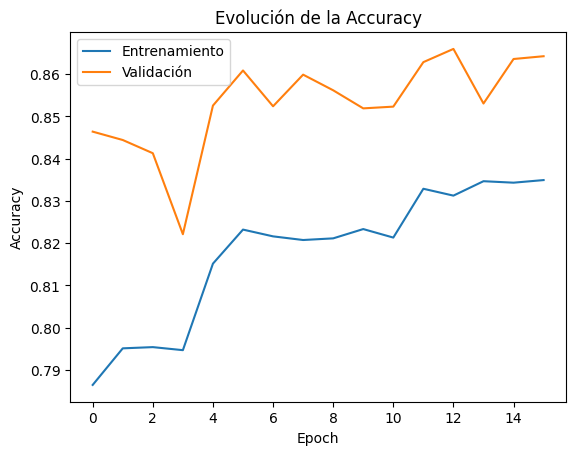

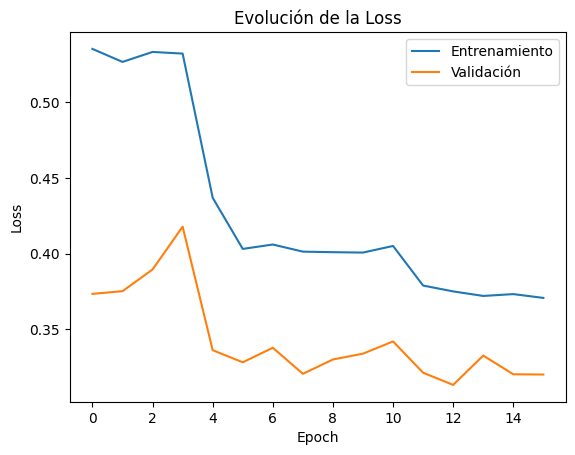

In [14]:
import matplotlib.pyplot as plt


plt.plot(history.history['accuracy'], label='Entrenamiento')
plt.plot(history.history['val_accuracy'], label='Validación')
plt.title('Evolución de la Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

plt.plot(history.history['loss'], label='Entrenamiento')
plt.plot(history.history['val_loss'], label='Validación')
plt.title('Evolución de la Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()


In [15]:
from tensorflow.keras.models import load_model

model = load_model('/kaggle/input/modeloooo/model (2).h5')

In [16]:
test_loss, test_acc = model.evaluate(test_gen, steps=test_steps)
print(f"Test loss: {test_loss:.4f}")
print(f"Test accuracy: {test_acc:.4f}")


1341/1341 ━━━━━━━━━━━━━━━━━━━━ 31s 19ms/step - accuracy: 0.8713 - loss: 0.3079
Test loss: 0.3138
Test accuracy: 0.8653


1342/1342 ━━━━━━━━━━━━━━━━━━━━ 31s 20ms/step
=== Classification report (test) ===
              precision    recall  f1-score   support

          IA     0.8498    0.8876    0.8683      5366
        Real     0.8824    0.8431    0.8623      5365

    accuracy                         0.8653     10731
   macro avg     0.8661    0.8653    0.8653     10731
weighted avg     0.8661    0.8653    0.8653     10731



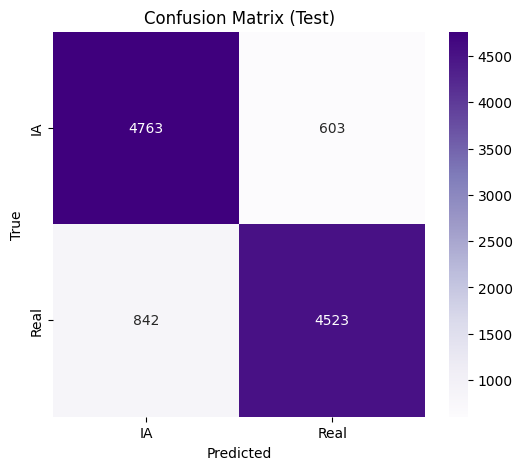

In [17]:
import math
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix


test_gen = data_generator(test_subset, shuffle=False)
steps_test = math.ceil(len(test_subset) / BATCH_SIZE)


y_pred_probs = model.predict(test_gen, steps=steps_test)
y_pred = np.argmax(y_pred_probs, axis=1)
y_true = np.array([s["label"] for s in test_subset])


class_names = ["IA", "Real"]
print("=== Classification report (test) ===")
print(classification_report(
    y_true,
    y_pred,
    labels=[0, 1],
    target_names=class_names,
    digits=4
))


cm = confusion_matrix(y_true, y_pred, labels=[0, 1])

plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Purples',
            xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix (Test)')
plt.show()


AUC (test): 0.9420


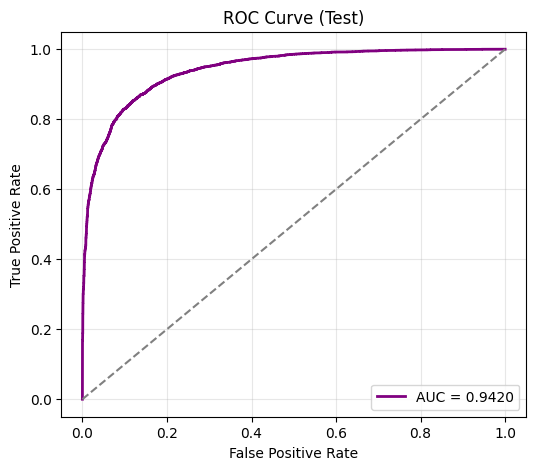

In [18]:
from sklearn.metrics import roc_auc_score, roc_curve, auc
import matplotlib.pyplot as plt

y_pred_prob_class1 = y_pred_probs[:, 1]
auc_score = roc_auc_score(y_true, y_pred_prob_class1)
print(f"AUC (test): {auc_score:.4f}")
fpr, tpr, thresholds = roc_curve(y_true, y_pred_prob_class1)

plt.figure(figsize=(6,5))
plt.plot(fpr, tpr, color='purple', lw=2, label=f'AUC = {auc_score:.4f}')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve (Test)')
plt.legend(loc='lower right')
plt.grid(alpha=0.3)
plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step


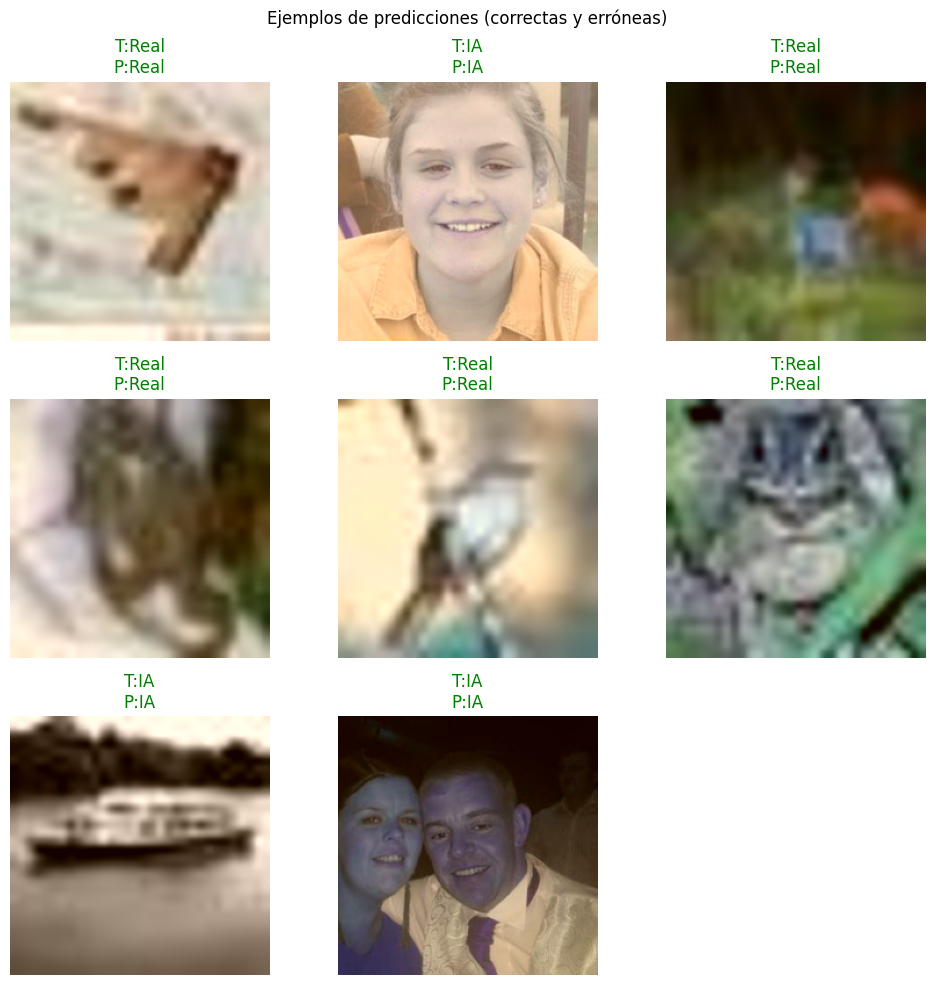

In [19]:
import numpy as np
import matplotlib.pyplot as plt
import random


def deprocess_resnet(x):
    """
    Revierte el preprocess_input de ResNet para visualizar imágenes correctamente.
    """
    x = x.copy()
    x[..., 0] += 123.68
    x[..., 1] += 116.779
    x[..., 2] += 103.939
    x = np.clip(x, 0, 255).astype("uint8")
    return x


x_batch, y_batch = next(test_gen)
y_pred_probs = model.predict(x_batch)
y_pred_batch = np.argmax(y_pred_probs, axis=1)


num_images = min(9, len(x_batch))  
plt.figure(figsize=(10,10))
for i, idx in enumerate(random.sample(range(len(x_batch)), num_images)):
    plt.subplot(3,3,i+1)
    

    img_show = deprocess_resnet(x_batch[idx])
    plt.imshow(img_show)
    true_label = class_names[y_batch[idx]]
    pred_label = class_names[y_pred_batch[idx]]
    color = "green" if true_label == pred_label else "red"
    plt.title(f"T:{true_label}\nP:{pred_label}", color=color)
    plt.axis("off")

plt.suptitle("Ejemplos de predicciones (correctas y erróneas)")
plt.tight_layout()
plt.show()
